# Projeto Titanic

Neste notebook contém a estretégia que utilizei para participar da competição: Titanic - Machine Learning from Disaster da plataforma Kaggle. O objetivo é utilizar machine learning para prever os passageiros que sobreviveram ao naufrágio.

Os atributos do conjunto de dados são:

* `PassengerId`: Id do passageiro
* `Survived`: sobrevivência (0 = Não, 1 = Sim)
* `Pclass`: Classe do bilhete (1 = 1º, 2 = 2º, 3 = 3º)
* `Name`: Nome do passageiro
* `Sex`: Sexo
* `Age`: Idade em anos
* `SibSp`: Número de irmãos/cônjuges a bordo do Titanic
* `Parch`: Números de pais/filhos a bordo do Titanic
* `Ticket`: Número do bilhete
* `Fare`: Tarifa do passageiro
* `Cabin`: Número da cabine	
* `Embarked`: Porto de embarcação (C = Cherbourg, Q = Queenstown, S = Southampton)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('titanic_all.csv')

## Conhecendo o conjunto de dados

Nesta etapa, vamos obter algumas informações iniciais sobre nosso conjunto de dados

In [3]:
# Vizualizando parte do dataframe
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
#Vizualizando os atributos, valores nulos e os tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [5]:
# Medidas estatisticas sobre os dados numéricos
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


Observações:
* nos campos do atributo `Name` há um título de tratamento. Esta informação pode ser útil na análise.
* há campos nulos nos atributos `Age`, `Fare`, `Cabin` e `Embarked`. 
* O tipo de dados da coluna `Survived` deveria ser inteiro
* O campo `Fare` possui valores descrepantes

## Tratamento inicial dos dados

Vamos inserir o título de tratamento como um atributo do dataframe.

In [6]:
# Adiciona o campo título de tratamento no dataframe
separador = []
for nome in df['Name']:
    item = nome.split(' ')
    separador.append(item)
        
titulos = []
for item in separador:
    for nome in item:
        if ('.' in nome) and (nome != 'L.'):
            titulos.append(nome)
    
df['Title'] = titulos
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.


## Análise exploratória dos dados

Antes de realizar a limpeza dos dados e um tratamento mais profundo no dados, vamos obsevar como o conjunto de dados está distribuido, respondendo algumas questões. Para isto, vamos utilizar o conjunto de dados de treino que possui a informação da sobrevivência ou não dos passageiros.

In [7]:
treino = df[df['PassengerId'] <= 891]

### O sexo e a classe estão relacionadas com a sobrevivência?

In [8]:
def figura_sobrevivente_sexo_classe (df):
    
    #filtrando o conjunto de dados pelo sexo
    mulheres = df[df['Sex'] == 0]
    homens = df[df['Sex'] == 1]
    
    #Agrupando as informações de classe e contagem de sobreviventes
    grupo1 = mulheres.groupby(['Pclass','Survived']).agg(count=('Survived', 'count')) 
    grupo1 = grupo1.reset_index()

    grupo2 = homens.groupby(['Pclass','Survived']).agg(count=('Survived', 'count')) 
    grupo2 = grupo2.reset_index()
    
    #Gráfico
    figura = plt.figure(figsize=(14,7))

    figura.add_subplot(1,2,1)
    sns.set_style('darkgrid')
    sns.barplot(x="Pclass", y="count", hue="Survived", data=grupo1,palette='mako')   
    plt.ylabel("Contagem") 
    plt.ylim([0,350])
    plt.xlabel("Classe do bilhete")
    plt.title('Mulheres')

    figura.add_subplot(1,2,2)
    sns.set_style('darkgrid')
    sns.barplot(x="Pclass", y="count", hue="Survived", data=grupo2,palette='mako')
    plt.ylabel("Contagem")
    plt.ylim([0,350])
    plt.xlabel("Classe do bilhete")
    plt.title('Homens')

    plt.show()

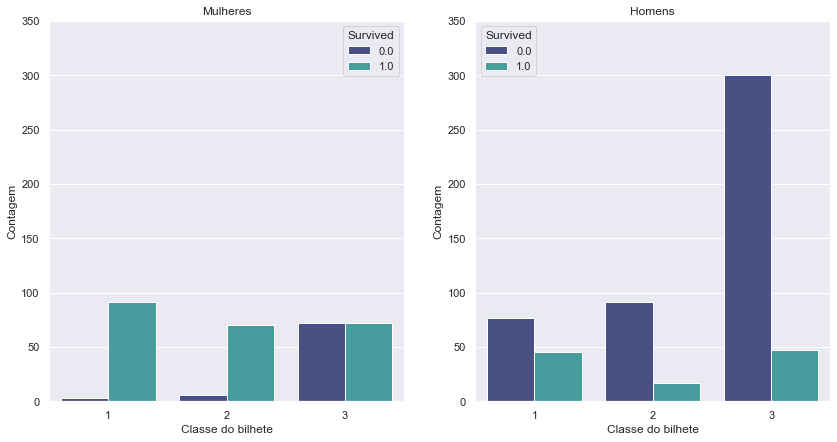

In [53]:
figura_sobrevivente_sexo_classe(treino)

Pelos gráficos acima, observamos que:
* a maioria da mulheres das classes 1 e 2 sobreviveram
* metade das mulheres classe 3 sobreviveram. 
* um terço dos homens da classe 1 sobreviveram  

### A idade está relacionada com a sobrevivência?

In [10]:
def figura_sobreviventes_idade(df):
    classe1 = df[df['Pclass'] == 1]
    classe2 = df[df['Pclass'] == 2]
    classe3 = df[df['Pclass'] == 3]
    
    figura = plt.figure(figsize=(30,10))
    sns.displot(classe1, x='Age', col="Survived", row="Pclass", binwidth=4, height=4, facet_kws=dict(margin_titles=True),color='r',legend='Pclass')
    plt.legend('1')
    sns.displot(classe2, x='Age', col="Survived", row="Pclass",  binwidth=4, height=4, facet_kws=dict(margin_titles=True),color='g')
    plt.legend('2')
    sns.displot(classe3, x='Age', col="Survived", row="Pclass",  binwidth=4, height=4, facet_kws=dict(margin_titles=True),color='b')
    plt.legend('3')
    plt.show()

<Figure size 2160x720 with 0 Axes>

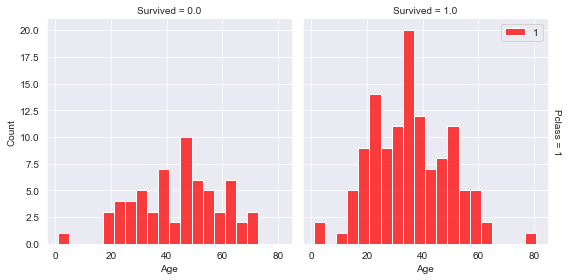

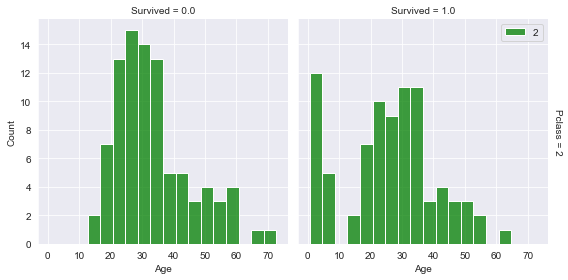

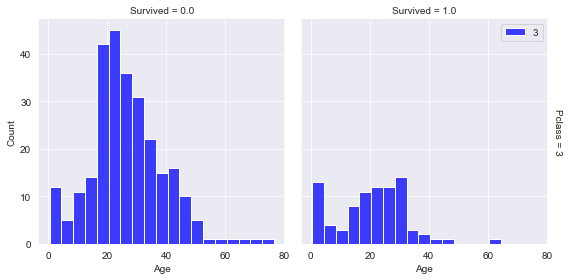

In [11]:
figura_sobreviventes_idade(treino)

Nos gráficos acima, observamos que:
* as crianças e adolescentes da classe 1 sobreviveram. 
* as crianças da classe 2 sobreviveram

### Como está a distribuição das classes por cabines? 

Observamos que o identificador inicial da cabine é uma letra. Vamos usar esse identificador para tratar os valores nulos.

In [12]:
#Substituindo os valores nulos da coluna Cabin pela letra N (depois vamos tratar esses dados adequadamente)
df['Cabin'].fillna('N', inplace=True)

In [13]:
#Criando o atributo de identificação das cabines
tipo_cabine = []
for cabine in df['Cabin']:
    tipo_cabine.append(cabine[0])

df['Cabin_Id'] = tipo_cabine

In [14]:
#Classificando os registros por identicador da Cabine
grupo3 = df.groupby(['Pclass','Cabin_Id']).agg(Count=('Cabin_Id', 'count')) 
grupo3 = grupo3.reset_index()
grupo31 = grupo3[grupo3['Cabin_Id'] != 'N']

<Figure size 720x720 with 0 Axes>

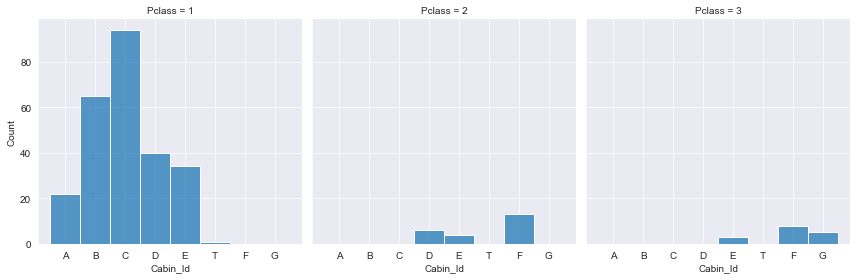

In [15]:
#Plotando os gráficos
figura = plt.figure(figsize=(10,10))
sns.displot(grupo31, x='Cabin_Id', col="Pclass", weights='Count', binwidth=4, height=4, facet_kws=dict(margin_titles=True))
plt.show()

Observamos que:
* Os passageiros da Classe 1 estão distribuidos nas cabines: A, B, C, D, E e T
* Os passageiros da Classe 2 estão distribuidos nas cabines: D, E e F
* Os passageiros da Classe 3 estão distribuidos nas cabines: E, F e G

### Cabine interferiu na sobrevivencia dos participantes da classe 3?

In [16]:
filtro = df[df['Pclass'] == 3]
grupo4 = filtro.groupby(['Survived','Cabin_Id']).agg(Count=('Cabin_Id', 'count')) 
grupo4 = grupo4.reset_index()
grupo41 = grupo4[grupo4['Cabin_Id'] != 'N']

<Figure size 720x720 with 0 Axes>

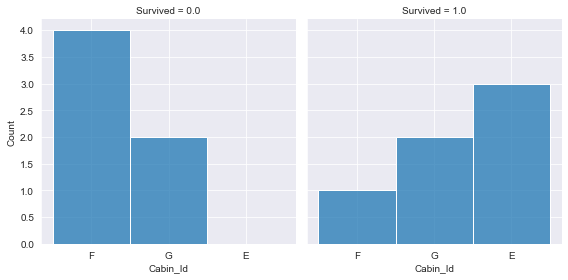

In [17]:
figura = plt.figure(figsize=(10,10))
sns.displot(grupo41, x='Cabin_Id', col="Survived", weights='Count', binwidth=4, height=4, facet_kws=dict(margin_titles=True))
plt.show()

Apesar da pouca quantidade de dados, podemos supor que as pessoas da classe 3 que estavam na cabine E sobreviveram.

### Qual é a variação dos preços do Ticket por Cabine? 

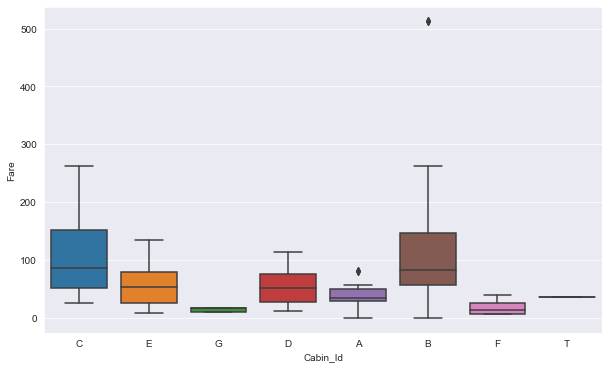

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(x="Cabin_Id", y="Fare", data = df[df['Cabin_Id']!='N'])
plt.show()

Para limpeza de dados é razoável supormos que os passageiros das classes 2 e 3 cujo:
* Fare > 25 estão na Cabine E
* Fare entre (17 e 25) estão na Cabine F
* Fare entre < 17 estão na Cabine G

### Ter parentes a bordo implicou em sobrevivência?  

In [19]:
#Inserindo o atributo Parent
condition1 = [ (df['Parch'] == 0), (df['Parch'] > 0)]
choice1 = [0, 1]
df['Parent1'] = np.select(condition1, choice1)

condition2 = [ (df['SibSp'] == 0), (df['SibSp'] > 0)]
choice2 = [0, 1]
df['Parent2'] = np.select(condition2, choice2)
                          
df['Parent3'] = df['Parent1'] + df['Parent2']

condition4 = [(df['Parent3'] == 0), (df['Parent3'] > 0)]
choice4 = [0, 1]
df['Parent'] = np.select(condition4, choice4)

del df['Parent1']
del df['Parent2']
del df['Parent3']

In [20]:
df.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_Id,Parent
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N,S,Mr.,N,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,N,S,Miss.,N,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,C,1


In [21]:
grupo5 = df.groupby(['Pclass','Parent']).agg(Count=('Survived', 'count')) 
grupo5 = grupo5.reset_index()
grupo5

,Pclass,Parent,Count
0,1,0,109
1,1,1,107
2,2,0,104
3,2,1,80
4,3,0,324
5,3,1,167


Observamos que há existência de um parente contribui para sobrevivência, principalmente na Classe 3.

## Limpeza dos dados

### Idades nulas

Vamos substituir a idade pela média do título de tratamento.

In [22]:
def idade_nula_por_titulo(df):
    filtro = df[df['Age'].isnull()]
    quantidade = filtro.groupby(['Title']).count()
    return quantidade.index

In [23]:
#Retorna os títulos que possuem idade nula
idade_nula_por_titulo(df)

Index(['Dr.', 'Master.', 'Miss.', 'Mr.', 'Mrs.', 'Ms.'], dtype='object', name='Title')

In [24]:
#Média das idades por título
medias_idade = df.groupby(['Title']).agg(Median=('Age', 'median')) 
medias_idade = medias_idade.reset_index()
medias_idade

,Title,Median
0,Capt.,70.0
1,Col.,54.5
2,Countess.,33.0
3,Don.,40.0
4,Dona.,39.0
5,Dr.,49.0
6,Jonkheer.,38.0
7,Lady.,48.0
8,Major.,48.5
9,Master.,4.0


In [25]:
def add_idade_nula(df):
    Dr = df[df['Title']=='Dr.']
    indicesDR = Dr[Dr['Age'].isnull() == True].index
    
    Master = df[df['Title']=='Master.']
    indicesMaster = Master[Master['Age'].isnull() == True].index
    
    Miss = df[df['Title']=='Miss.']
    indicesMiss = Miss[Miss['Age'].isnull() == True].index

    Mr = df[df['Title']=='Mr.']
    indicesMr = Mr[Mr['Age'].isnull() == True].index

    Mrs = df[df['Title']=='Mrs.']
    indicesMrs = Mrs[Mrs['Age'].isnull() == True].index

    Ms = df[df['Title']=='Ms.']
    indicesMs = Ms[Ms['Age'].isnull() == True].index

    for indice in indicesDR:
        df.at[indice,'Age'] = 49.0
    
    for indice in indicesMaster:
        df.at[indice,'Age'] = 4.0
    
    for indice in indicesMiss:
        df.at[indice,'Age'] = 22.0
    
    for indice in indicesMr:
        df.at[indice,'Age'] = 29.0
    
    for indice in indicesMrs:
        df.at[indice,'Age'] = 35.5
        
    for indice in indicesMs:
        df.at[indice,'Age'] = 28.0

In [26]:
# Adiciona as idades nulas de acordo com o título
add_idade_nula(df)

### Categorizando a idade

Vamos inserir uma categorização para idade. Isso pode contribuir para eficácia do processo de predição de dados.

In [27]:
#Categorizando a idade
conditionlist = [ (df['Age'] < 18), (df['Age'] < 50), (df['Age'] >= 50) ]
choicelist = ['Jovem', 'Adulto','Idoso']
df['Age_group'] = np.select(conditionlist, choicelist,)

### Cabines nulas

In [28]:
#Substituindo as cabines nulas da Classe 1 por B
C1 = df[df['Pclass'] == 1]
indicesC1 = C1[C1['Cabin_Id'] == 'N'].index

for indice in indicesC1:
    df.at[indice,'Cabin_Id'] = 'B'

In [29]:
#Substituindo as cabines nulas da Classe 2 pelo valor de Fare
#Fare > 25 estão na Cabine E
#Fare entre (17 e 25) estão na Cabine F
#Fare entre < 17 estão na Cabine G

C2 = df[df['Pclass'] == 2]
indicesC2 = C2[C2['Cabin_Id'] == 'N'].index

for indice in indicesC2:
    if df.at[indice,'Fare'] > 25:
        df.at[indice,'Cabin_Id'] = 'E'
    else:
        if df.at[indice,'Fare'] > 17:
            df.at[indice,'Cabin_Id'] = 'F'
        else:
            df.at[indice,'Cabin_Id'] = 'G'

In [30]:
#Substituindo as cabines nulas da Classe 3 pelo valor de Fare
#Fare > 25 estão na Cabine E
#Fare entre (17 e 25) estão na Cabine F
#Fare entre < 17 estão na Cabine G

C2 = df[df['Pclass'] == 3]
indicesC2 = C2[C2['Cabin_Id'] == 'N'].index

for indice in indicesC2:
    if df.at[indice,'Fare'] > 25:
        df.at[indice,'Cabin_Id'] = 'E'
    else:
        if df.at[indice,'Fare'] > 17:
            df.at[indice,'Cabin_Id'] = 'F'
        else:
            df.at[indice,'Cabin_Id'] = 'G'

### Demais campos nulos

Nos demais atributos, vamos substituir o campos nulos pela maior ocorrência ou pela média

In [31]:
#Substituindo os valores nulos da coluna Embarked por S
df['Embarked'].fillna('S',inplace=True)

In [32]:
#Substituindo os valores nulos da coluna Fare pela média
media = df['Fare'].mean()
df['Fare'].fillna(media,inplace=True)

### Valores discrepantes de Fare

Valores descrepantes podem atrapalhar o desempenho de algoritmos de machine learning, deste modo vamos tratar esses dados.

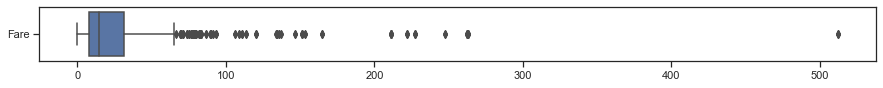

In [33]:
atributos = ['Fare']
plt.figure(figsize=(15,1))
sns.set_theme(style="ticks")
sns.boxplot(data=df[atributos], orient='h')
plt.show()

In [34]:
#Determinando os outliers do campo Fare
Q1 = np.percentile(df['Fare'],25)
Q3 = np.percentile(df['Fare'],75)
AIQ = Q3 - Q1
LI = Q1 - 1.5 * AIQ 
LS = Q3 + 1.5 * AIQ

In [35]:
#Substituindo os outliers pelo limite superior
conditionlist = [ (df['Fare'] <= LS), (df['Fare'] > LS) ]
choicelist = [df['Fare'], LS]
df['Fare'] = np.select(conditionlist, choicelist)

## Conversão de dados

In [36]:
#Verificando se as colunas estão com tipo correto de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   object 
 13  Cabin_Id     1309 non-null   object 
 14  Parent       1309 non-null   int32  
 15  Age_group    1309 non-null   object 
dtypes: float64(3), int32(1), int64(4), object(8)
memory usage: 158.6+ KB


### Convertendo dados categoricos em numéricos

In [37]:
from sklearn.preprocessing import LabelEncoder

In [38]:
conversao1 = LabelEncoder().fit_transform(df['Sex'])
conversao2 = LabelEncoder().fit_transform(df['Embarked'])
conversao3 = LabelEncoder().fit_transform(df['Cabin_Id'])
conversao4 = LabelEncoder().fit_transform(df['Title'])
conversao5 = LabelEncoder().fit_transform(df['Age_group'])
df['Sex'] = conversao1
df['Embarked'] = conversao2
df['Cabin_Id'] = conversao3
df['Title'] = conversao4
df['Age_group'] = conversao5

## Verificando o conjunto de dados

In [39]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_Id,Parent,Age_group
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,N,2,13,6,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,66.3438,C85,0,14,2,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,N,2,10,6,0,0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   int32  
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   int32  
 12  Title        1309 non-null   int32  
 13  Cabin_Id     1309 non-null   int32  
 14  Parent       1309 non-null   int32  
 15  Age_group    1309 non-null   int32  
dtypes: float64(3), int32(6), int64(4), object(3)
memory usage: 133.1+ KB


## Predição de dados

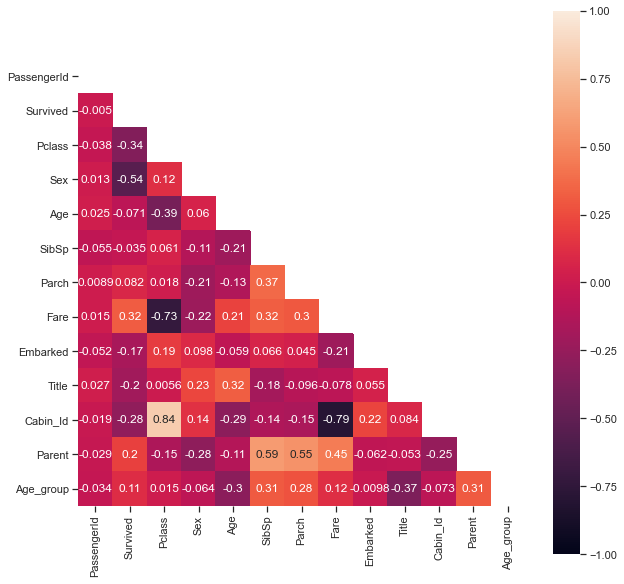

In [41]:
#Verificando a correlação dos dados
filtro = np.triu(np.ones_like(df.corr(),dtype=np.bool_))
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), mask=filtro, square=True,annot=True,vmin=-1,vmax=1)
plt.show()

In [42]:
#Escolhendo os parametros X da predição:}
parametros = ['Pclass','Sex','Age_group','Fare','Embarked','Title','Cabin_Id','Parent','Age']

In [43]:
#Informando o conjunto de treino e teste
treino = pd.DataFrame(df[df['PassengerId'] <= 891])
teste = pd.DataFrame(df[df['PassengerId'] > 891])

In [44]:
#Informando as variáveis de predição (x) e a variável alvo (y) para os conjuntos de treino e teste
X_treino = treino[parametros]
y_treino = treino['Survived']

X_teste = teste[parametros]

In [45]:
#Escolhendo o algoritmo
from sklearn.ensemble import RandomForestClassifier
modelo = RandomForestClassifier(n_estimators=42, random_state=1)

In [46]:
#Treinando o modelo
modelo.fit(X_treino, y_treino)

RandomForestClassifier(n_estimators=42, random_state=1)

In [47]:
#Performace do modelo no treino
from sklearn import metrics
predicao_treino = modelo.predict(X_treino)
print('Acurácia no treino: {0:.4f} '.format( metrics.accuracy_score(y_treino,predicao_treino )))

Acurácia no treino: 0.9809 


In [48]:
#Aplicando o modelo no teste
predicao_teste = modelo.predict(X_teste).astype(int)

In [49]:
#Inserindo a predição no teste
teste['Survived']=predicao_teste
teste

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_Id,Parent,Age_group
891,892,0,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,N,1,13,6,0,0
892,893,0,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,N,2,14,6,1,0
893,894,1,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,N,1,13,6,0,1
894,895,1,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,N,2,13,6,0,0
895,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,N,2,14,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,"Spector, Mr. Woolf",1,29.0,0,0,A.5. 3236,8.0500,N,2,13,6,0,0
1305,1306,1,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,66.3438,C105,0,4,2,0,0
1306,1307,0,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,N,2,13,6,0,0
1307,1308,0,3,"Ware, Mr. Frederick",1,29.0,0,0,359309,8.0500,N,2,13,6,0,0


## Vizualizando os resultados

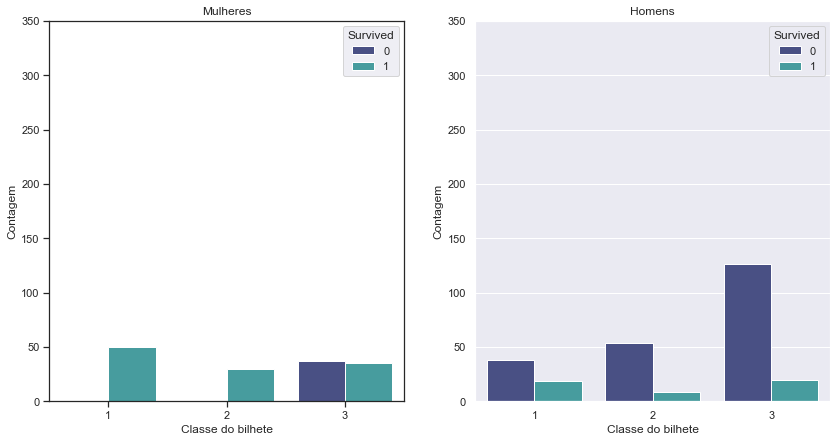

In [50]:
figura_sobrevivente_sexo_classe(teste)

<Figure size 2160x720 with 0 Axes>

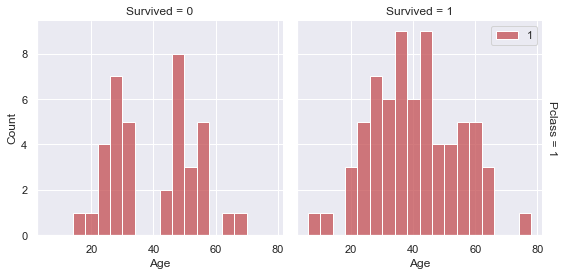

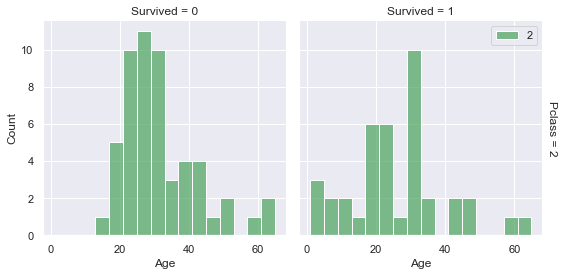

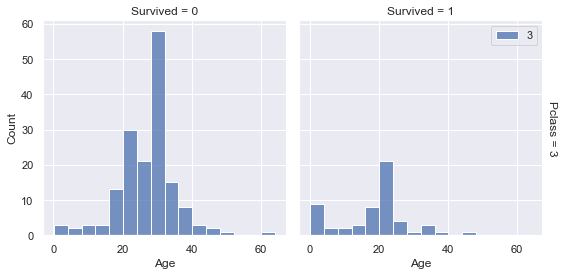

In [51]:
figura_sobreviventes_idade(teste)

In [52]:
#Salvando o resultado
resultado = teste[['PassengerId','Survived']]
resultado.astype(int)
resultado.to_csv('resultado',index=False)

## Conclusão

Este trabalho resultou numa acurácia de 74.64% com dados de teste na plataforma Kaggle. O resultado deve ser melhorado. 
Para isso, precisamos:
* Identificar de forma mais adequada os sobreviventes homens